# Clinical Benefit Fairness

Gaylen Fronk  
January 15, 2025

## Set Up Environment

In [ ]:
study <- "match"
version <- "v6"
cv <- "nested"
y_col_name <- "pp_hybrid_wk4_outcome"


Function conflicts

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

Packages, functions, and paths

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

ℹ SHA-1 hash of file is "6e9288d22f09da9ec15a1d5c046a0b6736ecce8b"

## Prepare data

Read in demographics

In [ ]:
d_dem <- read_csv(file.path(path_processed, "match_cln.csv"), 
              show_col_types = FALSE) |> 
  select(subid, gender_ehr, race_ehr, ethnicity_ehr, income_order) |> 
  mutate(sex = if_else(gender_ehr == "female", "Female", "Male"),
         race_ethnicity = if_else(race_ehr == "white" & ethnicity_ehr == "non_hispanic",
                                  "White/Non-Hispanic", "Not White"),
         income = case_match(
           income_order,
           c("01_less_than_10000", "02_btwn_10000_19999", 
             "03_btwn_20000_24999") ~ "Below Poverty Line",
           c("04_btwn_25000_34999", "05_btwn_35000_49999", 
             "06_btwn_50000_74999", "07_more_than_75000") ~ "Above Poverty Line",
           NA_character_ ~ "Missing")) |> 
  select(-income_order, -ends_with("ehr")) |> 
  glimpse()


Rows: 1,086
Columns: 4
$ subid          <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 20086,…
$ sex            <chr> "Female", "Female", "Female", "Female", "Female", "Fema…
$ race_ethnicity <chr> "White/Non-Hispanic", "White/Non-Hispanic", "White/Non-…
$ income         <chr> "Below Poverty Line", "Above Poverty Line", "Above Pove…

Read in aim 2 dataset

In [ ]:
d_ben <- read_csv(file.path(path_models, 
                        str_c("aim_2_", version, "_", y_col_name, ".csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(c_tx_match = if_else(tx_match == TRUE, 0.5, -0.5), # center
         week = as.numeric(week))

glimpse(d_ben)


Rows: 3,258
Columns: 13
$ subid            <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 2003…
$ tx_rct           <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_best          <chr> "varenicline", "varenicline", "varenicline", "varenic…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ tx_worst         <chr> "combo_nrt", "combo_nrt", "combo_nrt", "patch", "patc…
$ tx_second        <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ prob_best        <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ prob_patch       <dbl> 0.2080906, 0.2080906, 0.2080906, 0.4220443, 0.4220443…
$ prob_combo_nrt   <dbl> 0.1754414, 0.1754414, 0.1754414, 0.4957828, 0.4957828…
$ prob_varenicline <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ week             <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26…
$ outcome_rct_num  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,…
$ c_tx_match    

Join

In [ ]:
d <- d_ben |> 
  left_join(d_dem, by = "subid") |> 
  glimpse()


Rows: 3,258
Columns: 16
$ subid            <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 2003…
$ tx_rct           <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_best          <chr> "varenicline", "varenicline", "varenicline", "varenic…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ tx_worst         <chr> "combo_nrt", "combo_nrt", "combo_nrt", "patch", "patc…
$ tx_second        <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ prob_best        <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ prob_patch       <dbl> 0.2080906, 0.2080906, 0.2080906, 0.4220443, 0.4220443…
$ prob_combo_nrt   <dbl> 0.1754414, 0.1754414, 0.1754414, 0.4957828, 0.4957828…
$ prob_varenicline <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ week             <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26…
$ outcome_rct_num  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,…
$ c_tx_match    

## Analyses

Centered variables

In [ ]:
d <- d |> 
  mutate(
    c_sex_male = if_else(sex == "Male", 0, 1),
    c_sex_female = if_else(sex == "Male", 1, 0),
    c_race_ethn_white_non_his = if_else(race_ethnicity == "White/Non-Hispanic", 0, 1),
    c_race_ethn_not_white = if_else(race_ethnicity == "White/Non-Hispanic", 1, 0),
    c_income_above = case_match(
      income,
      "Below Poverty Line" ~ 1,
      "Above Poverty Line" ~ 0,
      "Missing" ~ NA_real_
    ),
    c_income_below = case_match(
      income,
      "Below Poverty Line" ~ 0,
      "Above Poverty Line" ~ 1,
      "Missing" ~ NA_real_
    )
  ) |> 
  glimpse()


Rows: 3,258
Columns: 22
$ subid                     <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20…
$ tx_rct                    <chr> "patch", "patch", "patch", "combo_nrt", "com…
$ tx_best                   <chr> "varenicline", "varenicline", "varenicline",…
$ tx_match                  <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FA…
$ tx_worst                  <chr> "combo_nrt", "combo_nrt", "combo_nrt", "patc…
$ tx_second                 <chr> "patch", "patch", "patch", "combo_nrt", "com…
$ prob_best                 <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, …
$ prob_patch                <dbl> 0.2080906, 0.2080906, 0.2080906, 0.4220443, …
$ prob_combo_nrt            <dbl> 0.1754414, 0.1754414, 0.1754414, 0.4957828, …
$ prob_varenicline          <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, …
$ week                      <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, …
$ outcome_rct_num           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,…
$ c_tx_match    

Filter to week 4

In [ ]:
d_wk4 <- d |> 
  filter(week == 4)


### Race/ethnicity

Simple effect of White/Non-Hispanic at week 4

In [ ]:
white_4 <- glm(outcome_rct_num ~ c_tx_match * c_race_ethn_white_non_his,
                data = d_wk4,
                family = binomial(link = "logit"))

summary(white_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_race_ethn_white_non_his, 
    family = binomial(link = "logit"), data = d_wk4)

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                          -0.30372    0.07858  -3.865 0.000111 ***
c_tx_match                            0.18894    0.15716   1.202 0.229275    
c_race_ethn_white_non_his            -1.06315    0.15525  -6.848  7.5e-12 ***
c_tx_match:c_race_ethn_white_non_his  0.58315    0.31051   1.878 0.060372 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1326.5  on 1082  degrees of freedom
AIC: 1334.5

Number of Fisher Scoring iterations: 4

c_tx_match 
  1.207966 

Simple effect of Non-White at week 4

In [ ]:
nonwhite_4 <- glm(outcome_rct_num ~ c_tx_match * c_race_ethn_not_white,
                data = d_wk4,
                family = binomial(link = "logit"))

summary(nonwhite_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_race_ethn_not_white, 
    family = binomial(link = "logit"), data = d_wk4)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -1.3669     0.1339 -10.208  < 2e-16 ***
c_tx_match                         0.7721     0.2678   2.883  0.00394 ** 
c_race_ethn_not_white              1.0632     0.1553   6.848  7.5e-12 ***
c_tx_match:c_race_ethn_not_white  -0.5832     0.3105  -1.878  0.06037 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1326.5  on 1082  degrees of freedom
AIC: 1334.5

Number of Fisher Scoring iterations: 4

c_tx_match 
  2.164286 

Overall effect OR: 1.38 White/non-Hispanic OR: 1.208 Non-White OR: 2.164

`summarise()` has grouped output by 'race_ethn_cat'. You can override using the
`.groups` argument.

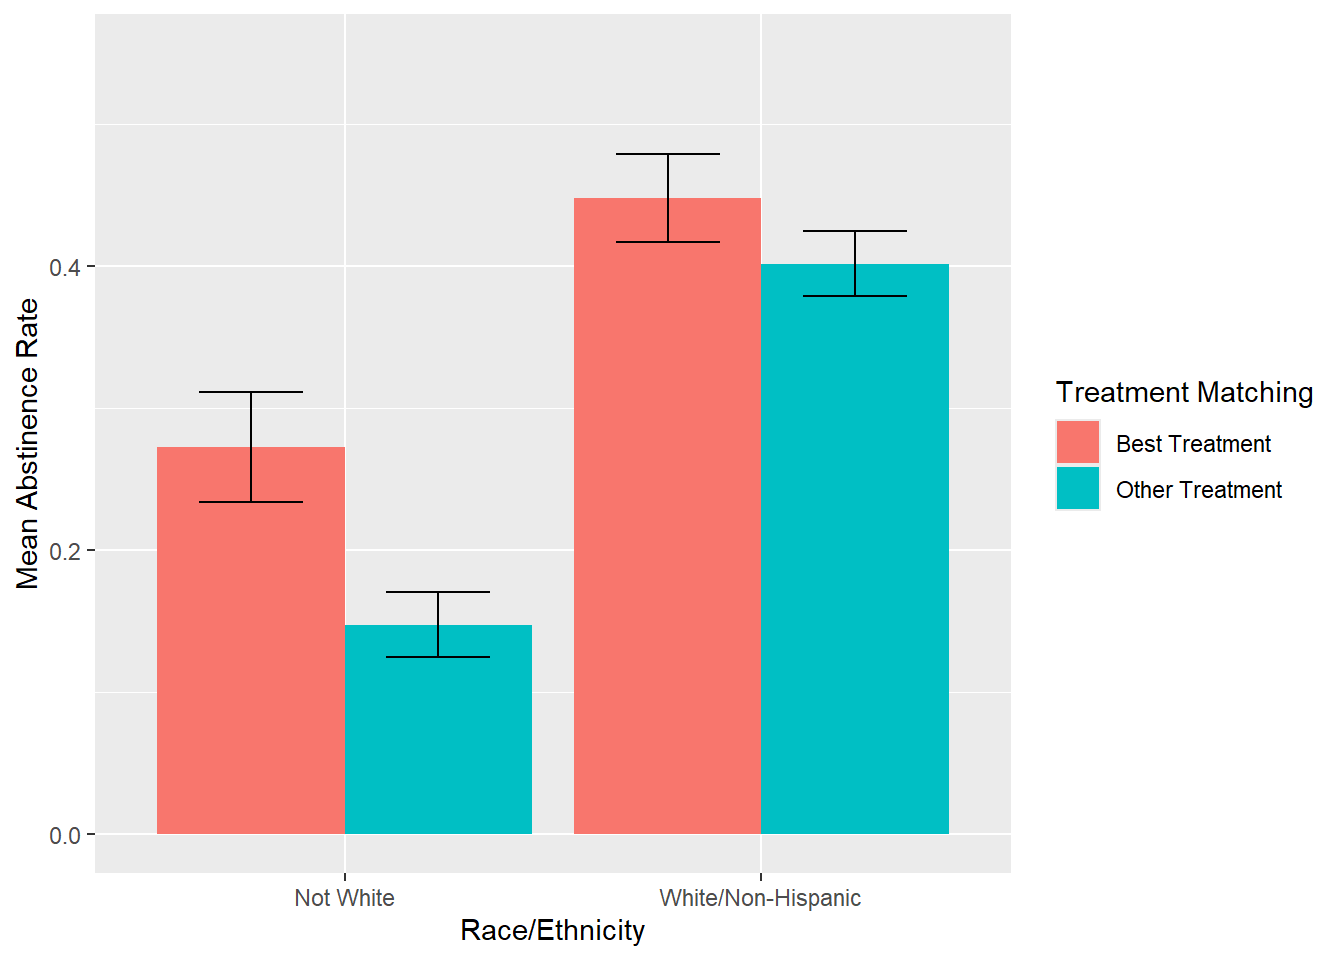

In [ ]:
fig_clin_ben_race <- d_wk4 |> 
  mutate(race_ethn_cat = factor(c_race_ethn_not_white,
                           levels = c(0, 1),
                           labels = c("Not White", "White/Non-Hispanic")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Best Treatment", "Other Treatment"))) |> 
  group_by(race_ethn_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = race_ethn_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = race_ethn_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.55)) +
  labs(
    x = "Race/Ethnicity",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )


### Sex

Simple effect of Male at week 4

In [ ]:
male_4 <- glm(outcome_rct_num ~ c_tx_match * c_sex_male,
                data = d_wk4,
                family = binomial(link = "logit"))

summary(male_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_sex_male, family = binomial(link = "logit"), 
    data = d_wk4)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.610322   0.096868  -6.301 2.97e-10 ***
c_tx_match             0.332781   0.193736   1.718   0.0859 .  
c_sex_male            -0.007436   0.132507  -0.056   0.9552    
c_tx_match:c_sex_male -0.016330   0.265013  -0.062   0.9509    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1388.7  on 1082  degrees of freedom
AIC: 1396.7

Number of Fisher Scoring iterations: 4

c_tx_match 
  1.394842 

Simple effect of Female at week 4

In [ ]:
female_4 <- glm(outcome_rct_num ~ c_tx_match * c_sex_female,
                data = d_wk4,
                family = binomial(link = "logit"))

summary(female_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_sex_female, family = binomial(link = "logit"), 
    data = d_wk4)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.617758   0.090414  -6.833 8.34e-12 ***
c_tx_match               0.316451   0.180827   1.750   0.0801 .  
c_sex_female             0.007436   0.132507   0.056   0.9552    
c_tx_match:c_sex_female  0.016330   0.265013   0.062   0.9509    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1388.7  on 1082  degrees of freedom
AIC: 1396.7

Number of Fisher Scoring iterations: 4

c_tx_match 
  1.372249 

Overall effect OR: 1.38 Female OR: 1.372 Male OR: 1.395

`summarise()` has grouped output by 'sex_cat'. You can override using the
`.groups` argument.

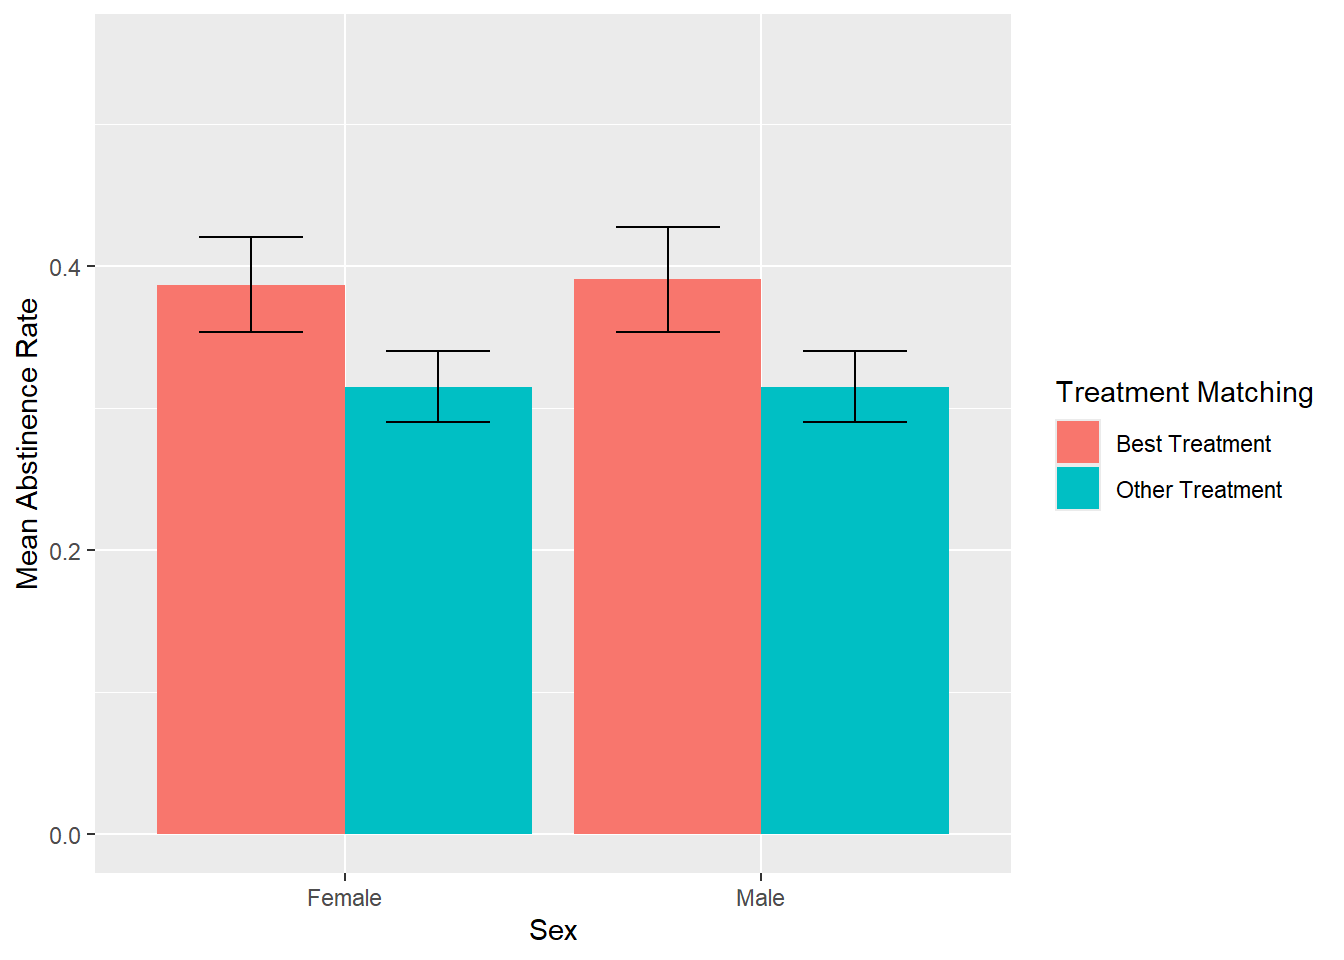

In [ ]:
fig_clin_ben_sex <- d_wk4 |> 
  mutate(sex_cat = factor(c_sex_female,
                           levels = c(0, 1),
                           labels = c("Female", "Male")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Best Treatment", "Other Treatment"))) |> 
  group_by(sex_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = sex_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = sex_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.55)) +
  labs(
    x = "Sex",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )


### Income

Need to remove subset of participants who did not provide income data.

In [ ]:
d_wk4_income <- d_wk4 |> 
  filter(income != "Missing") |> 
  mutate(c_income = if_else(income == "Above Poverty Line", -0.5, 0.5))


Overall week 4 (centered)

In [ ]:
centered_4 <- glm(outcome_rct_num ~ c_tx_match * c_income,
                data = d_wk4_income,
                family = binomial(link = "logit"))
summary(centered_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_income, family = binomial(link = "logit"), 
    data = d_wk4_income)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.69655    0.07259  -9.596  < 2e-16 ***
c_tx_match           0.39370    0.14517   2.712  0.00669 ** 
c_income            -0.83464    0.14517  -5.749 8.96e-09 ***
c_tx_match:c_income  0.06189    0.29034   0.213  0.83119    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1329.3  on 1032  degrees of freedom
Residual deviance: 1283.0  on 1029  degrees of freedom
AIC: 1291

Number of Fisher Scoring iterations: 4

c_tx_match 
   1.48245 

Simple effect of higher income at week 4

In [ ]:
above_4 <- glm(outcome_rct_num ~ c_tx_match * c_income_above,
                data = d_wk4_income,
                family = binomial(link = "logit"))

summary(above_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_income_above, 
    family = binomial(link = "logit"), data = d_wk4_income)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.27923    0.08502  -3.284  0.00102 ** 
c_tx_match                 0.36275    0.17004   2.133  0.03290 *  
c_income_above            -0.83464    0.14517  -5.749 8.96e-09 ***
c_tx_match:c_income_above  0.06189    0.29034   0.213  0.83119    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1329.3  on 1032  degrees of freedom
Residual deviance: 1283.0  on 1029  degrees of freedom
AIC: 1291

Number of Fisher Scoring iterations: 4

c_tx_match 
  1.437277 

Simple effect of low income at week 4

In [ ]:
below_4 <- glm(outcome_rct_num ~ c_tx_match * c_income_below,
                data = d_wk4_income,
                family = binomial(link = "logit"))

summary(below_4)



Call:
glm(formula = outcome_rct_num ~ c_tx_match * c_income_below, 
    family = binomial(link = "logit"), data = d_wk4_income)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1.11387    0.11767  -9.466  < 2e-16 ***
c_tx_match                 0.42464    0.23534   1.804   0.0712 .  
c_income_below             0.83464    0.14517   5.749 8.96e-09 ***
c_tx_match:c_income_below -0.06189    0.29034  -0.213   0.8312    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1329.3  on 1032  degrees of freedom
Residual deviance: 1283.0  on 1029  degrees of freedom
AIC: 1291

Number of Fisher Scoring iterations: 4

c_tx_match 
  1.529043 

Overall effect OR: 1.482 High income OR: 1.437 Low income OR: 1.529

`summarise()` has grouped output by 'income_cat'. You can override using the
`.groups` argument.

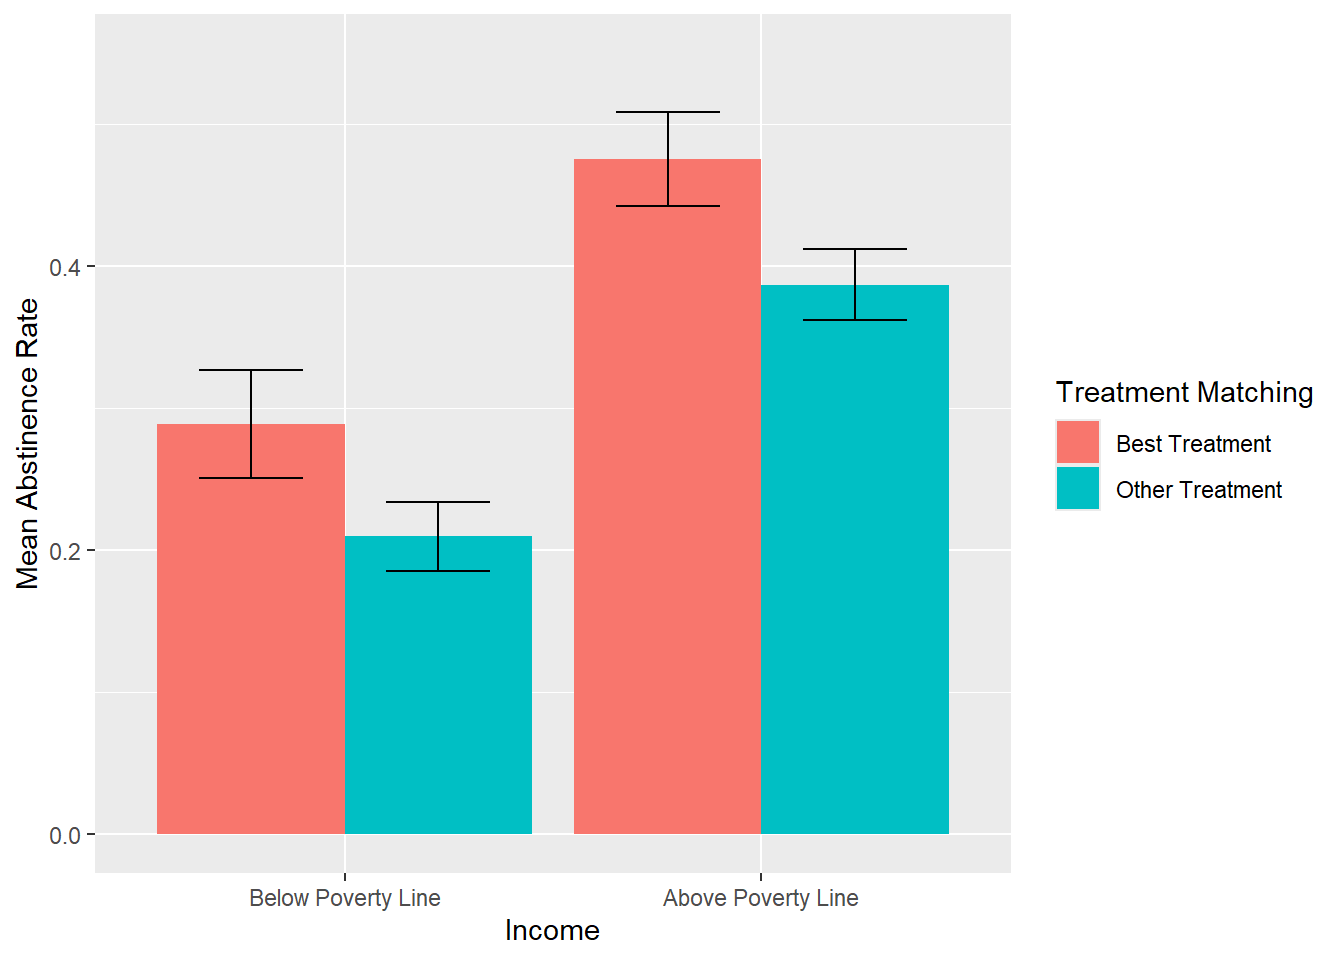

In [ ]:
fig_clin_ben_income <- d_wk4_income |> 
  mutate(income_cat = factor(c_income_above,
                           levels = c(1, 0),
                           labels = c("Below Poverty Line", "Above Poverty Line")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Best Treatment", "Other Treatment"))) |> 
  group_by(income_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = income_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = income_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.55)) +
  labs(
    x = "Income",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )
